In [439]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import warnings

warnings.filterwarnings("ignore")

pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
pd.set_option("display.width", None)
pd.set_option("display.max_colwidth", None)

plt.style.use("seaborn-v0_8")
sns.set_palette("husl")

### DATA CLEANING

In [440]:
column_names = [
    "hotel_name",
    "city", 
    "country",
    "price_per_night",
    "rating",
    "rating_status", 
    "review_count",
    "stars",
    "location",
    "distance_to_center",
    "transportation_options",
    "amenities",
]

df = pd.read_csv("vietnam_hotels_data.csv", names=column_names, na_values="?")

if df.iloc[0]['hotel_name'] == 'hotel_name':
    df = df.iloc[1:].reset_index(drop=True)

df["price_per_night"] = pd.to_numeric(df["price_per_night"], errors="coerce")
df["rating"] = pd.to_numeric(df["rating"], errors="coerce") 
df["review_count"] = pd.to_numeric(df["review_count"], errors="coerce")
df["stars"] = pd.to_numeric(df["stars"], errors="coerce")
df["distance_to_center"] = pd.to_numeric(df["distance_to_center"], errors="coerce")
df["rating_numeric"] = df["rating"]  
df["rating_text"] = df["rating_status"]

def count_transportation(transport_str):
    if pd.isna(transport_str) or transport_str == "[]":
        return 0
    try:
        if transport_str.startswith('[') and transport_str.endswith(']'):
            transport_list = eval(transport_str)
            return len(transport_list)
        else:
            return 0
    except:
        return 0

df["transportation_count"] = df["transportation_options"].apply(count_transportation)

def count_amenities(amenities_str):
    if pd.isna(amenities_str) or amenities_str == "[]":
        return 0
    try:
        if amenities_str.startswith('[') and amenities_str.endswith(']'):
            amenities_list = eval(amenities_str)
            return len(amenities_list)
        else:
            return 0
    except:
        return 0

df["amenities_count"] = df["amenities"].apply(count_amenities)

if "distance_to_center" in df.columns:
    distance_median = df["distance_to_center"].median()
    missing_distance = df["distance_to_center"].isnull().sum()
    if missing_distance > 0:
        print(f"Filling {missing_distance} missing distance values with median: {distance_median}")
        df["distance_to_center"].fillna(distance_median, inplace=True)

df["is_city_center"] = (df["distance_to_center"] == 0.0) | df["location"].str.contains("center", case=False, na=False)

city_dummies = pd.get_dummies(df["city"], prefix="city")
df = pd.concat([df, city_dummies], axis=1)

essential_columns = ["price_per_night", "rating", "stars"]
df_clean = df.dropna(subset=essential_columns).copy()

if "review_count" in df_clean.columns:
    review_median = df_clean["review_count"].median()
    missing_reviews = df_clean["review_count"].isnull().sum()
    if missing_reviews > 0:
        print(f"Filling {missing_reviews} missing review count values with median: {review_median}")
        df_clean["review_count"].fillna(review_median, inplace=True)

df = df_clean.copy()

df.info()

Filling 2 missing distance values with median: 0.7
<class 'pandas.core.frame.DataFrame'>
Index: 217 entries, 0 to 219
Data columns (total 27 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   hotel_name              217 non-null    object 
 1   city                    217 non-null    object 
 2   country                 217 non-null    object 
 3   price_per_night         217 non-null    int64  
 4   rating                  217 non-null    float64
 5   rating_status           217 non-null    object 
 6   review_count            217 non-null    int64  
 7   stars                   217 non-null    float64
 8   location                217 non-null    object 
 9   distance_to_center      217 non-null    float64
 10  transportation_options  217 non-null    object 
 11  amenities               217 non-null    object 
 12  rating_numeric          217 non-null    float64
 13  rating_text             217 non-null    object 
 

### EXPLORATORY DATA ANALYSIS

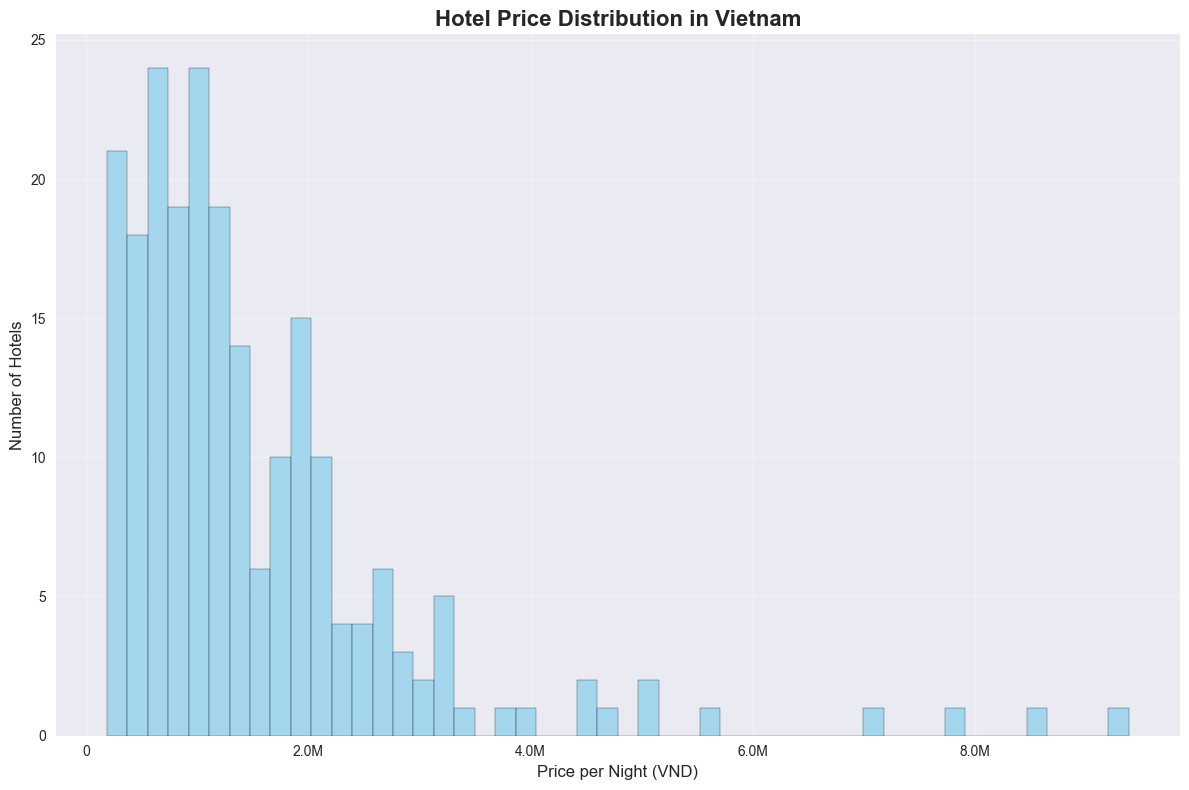

In [441]:
# 1. PRICE DISTRIBUTION
plt.figure(figsize=(12, 8))
plt.hist(
    df["price_per_night"].dropna(),
    bins=50,
    alpha=0.7,
    color="skyblue",
    edgecolor="black",
)
plt.title("Hotel Price Distribution in Vietnam", fontsize=16, fontweight="bold")
plt.xlabel("Price per Night (VND)", fontsize=12)
plt.ylabel("Number of Hotels", fontsize=12)
ax = plt.gca()
ax.xaxis.set_major_formatter(
    plt.FuncFormatter(
        lambda x, p: (
            f"{x/1e6:.1f}M" if x >= 1e6 else f"{x/1e3:.0f}K" if x >= 1e3 else f"{x:.0f}"
        )
    )
)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

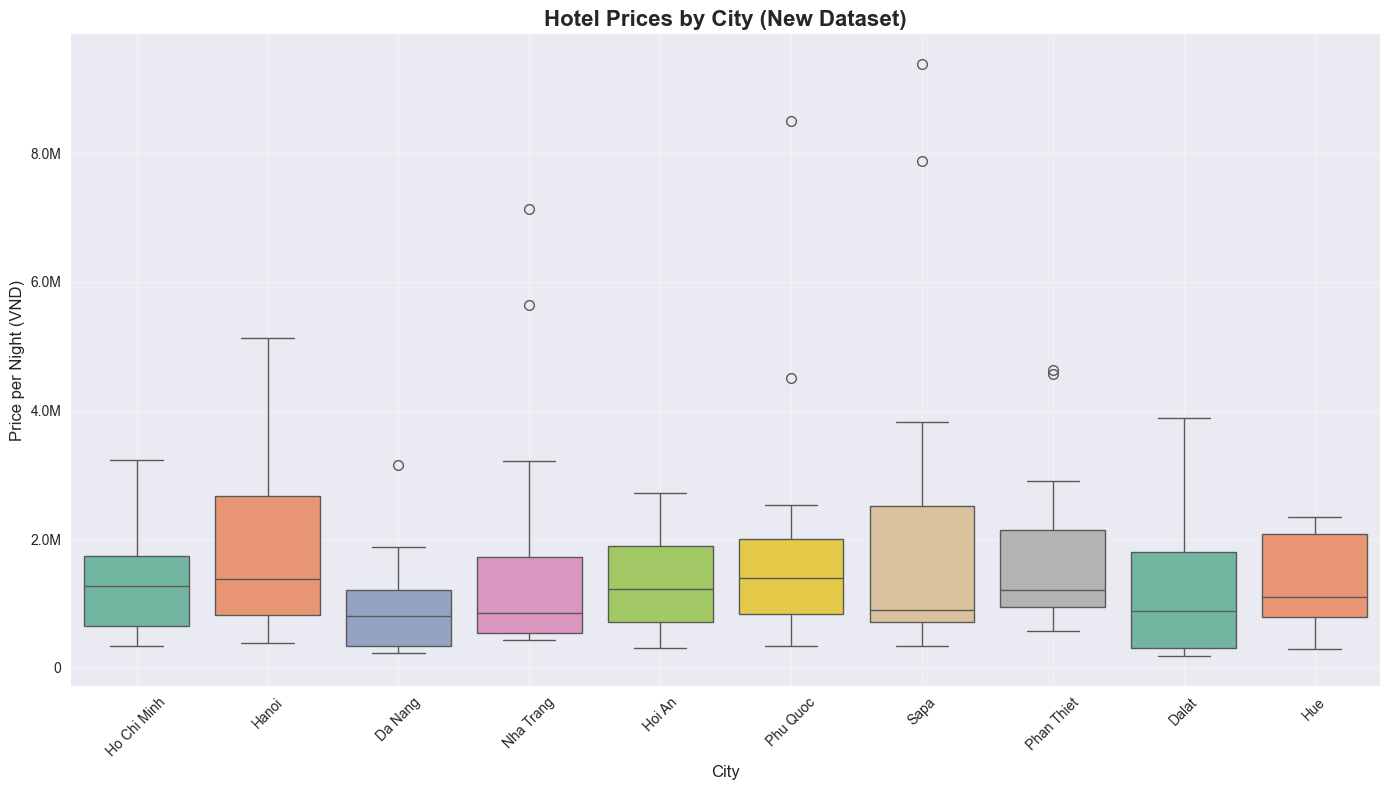

In [442]:
# 2. PRICE BY CITY
plt.figure(figsize=(14, 8))
sns.boxplot(data=df, x="city", y="price_per_night", palette="Set2")
plt.title("Hotel Prices by City (New Dataset)", fontsize=16, fontweight="bold")
plt.xlabel("City", fontsize=12)
plt.ylabel("Price per Night (VND)", fontsize=12)
plt.xticks(rotation=45)
ax = plt.gca()
ax.yaxis.set_major_formatter(
    plt.FuncFormatter(
        lambda x, p: (
            f"{x/1e6:.1f}M" if x >= 1e6 else f"{x/1e3:.0f}K" if x >= 1e3 else f"{x:.0f}"
        )
    )
)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

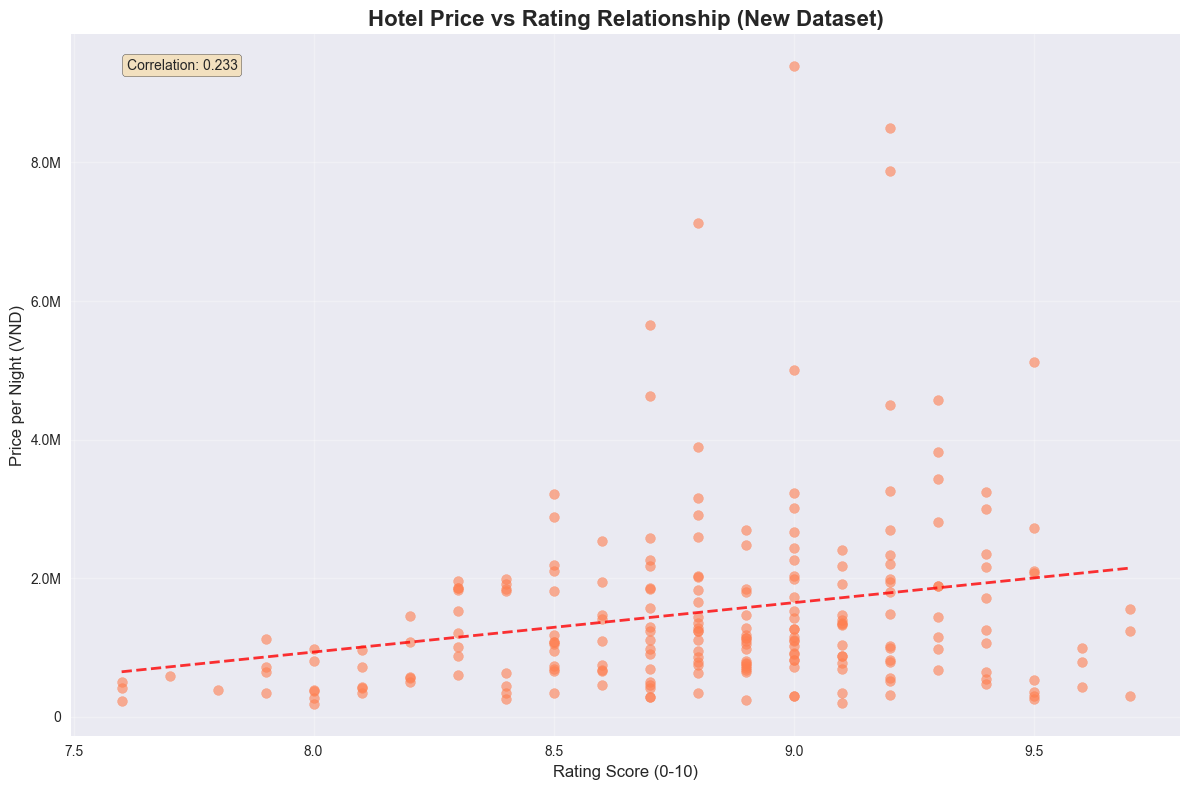

In [443]:
# 3. PRICE VS RATING (Updated for new numeric rating)
plt.figure(figsize=(12, 8))
plt.scatter(df["rating"], df["price_per_night"], alpha=0.6, color="coral", s=50)
plt.xlabel("Rating Score (0-10)", fontsize=12)
plt.ylabel("Price per Night (VND)", fontsize=12)
plt.title("Hotel Price vs Rating Relationship (New Dataset)", fontsize=16, fontweight="bold")

z = np.polyfit(df["rating"].dropna(), df.loc[df["rating"].notna(), "price_per_night"], 1)
p = np.poly1d(z)
plt.plot(df["rating"].dropna().sort_values(), p(df["rating"].dropna().sort_values()), "r--", alpha=0.8, linewidth=2)

ax = plt.gca()
ax.yaxis.set_major_formatter(
    plt.FuncFormatter(
        lambda x, p: (
            f"{x/1e6:.1f}M" if x >= 1e6 else f"{x/1e3:.0f}K" if x >= 1e3 else f"{x:.0f}"
        )
    )
)
plt.grid(True, alpha=0.3)

correlation = df["rating"].corr(df["price_per_night"])
plt.text(0.05, 0.95, f'Correlation: {correlation:.3f}', transform=plt.gca().transAxes, 
         bbox=dict(boxstyle="round", facecolor='wheat', alpha=0.8))

plt.tight_layout()
plt.show()

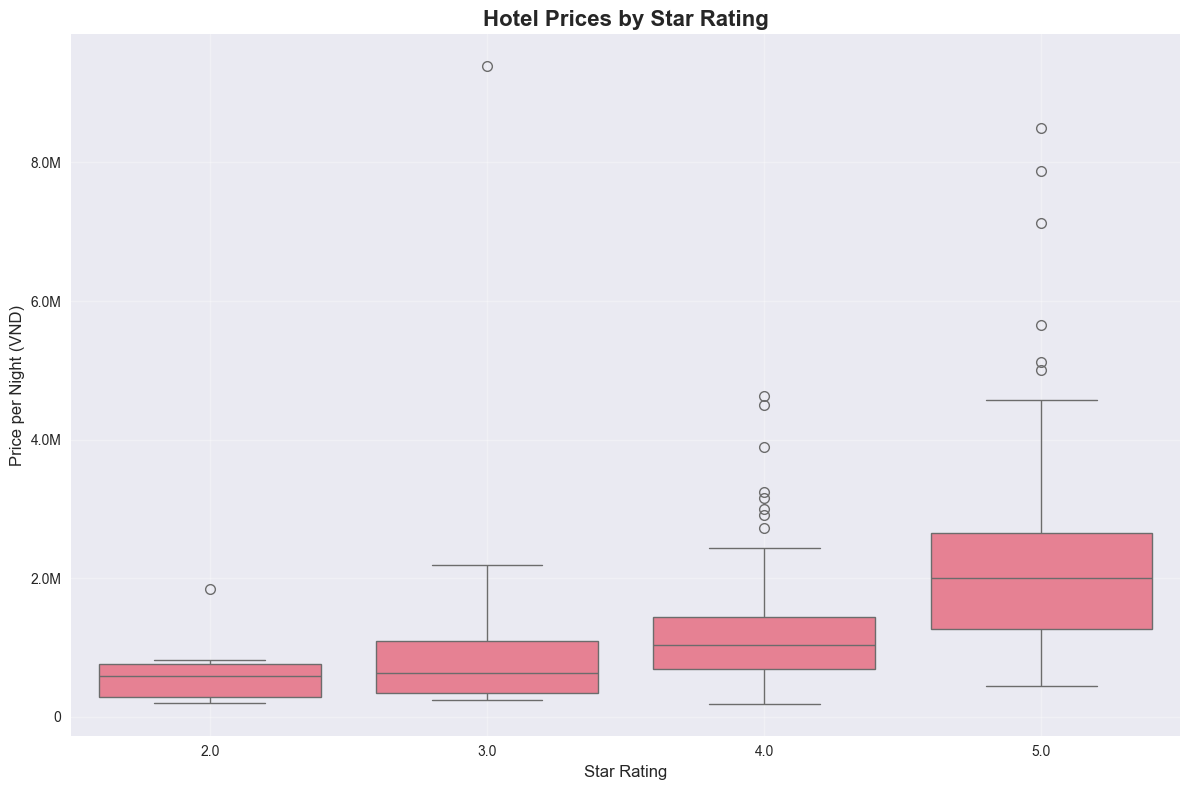

In [444]:
# 4. PRICE BY STAR RATING
plt.figure(figsize=(12, 8))
sns.boxplot(data=df, x="stars", y="price_per_night", ax=plt.gca())
plt.title("Hotel Prices by Star Rating", fontsize=16, fontweight="bold")
plt.xlabel("Star Rating", fontsize=12)
plt.ylabel("Price per Night (VND)", fontsize=12)
ax = plt.gca()
ax.yaxis.set_major_formatter(
    plt.FuncFormatter(
        lambda x, p: (
            f"{x/1e6:.1f}M" if x >= 1e6 else f"{x/1e3:.0f}K" if x >= 1e3 else f"{x:.0f}"
        )
    )
)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

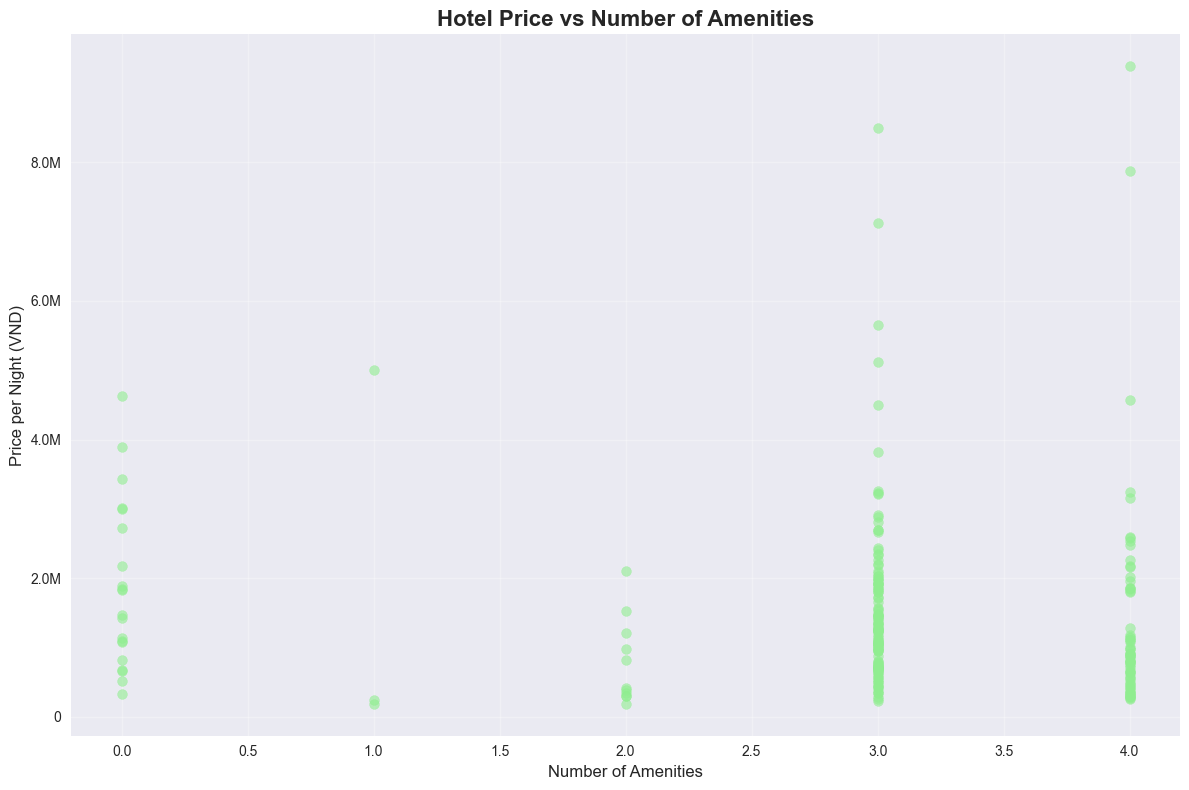

In [445]:
# 5. AMENITIES VS PRICE
plt.figure(figsize=(12, 8))
plt.scatter(
    df["amenities_count"], df["price_per_night"], alpha=0.6, color="lightgreen", s=50
)
plt.xlabel("Number of Amenities", fontsize=12)
plt.ylabel("Price per Night (VND)", fontsize=12)
plt.title("Hotel Price vs Number of Amenities", fontsize=16, fontweight="bold")
ax = plt.gca()
ax.yaxis.set_major_formatter(
    plt.FuncFormatter(
        lambda x, p: (
            f"{x/1e6:.1f}M" if x >= 1e6 else f"{x/1e3:.0f}K" if x >= 1e3 else f"{x:.0f}"
        )
    )
)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

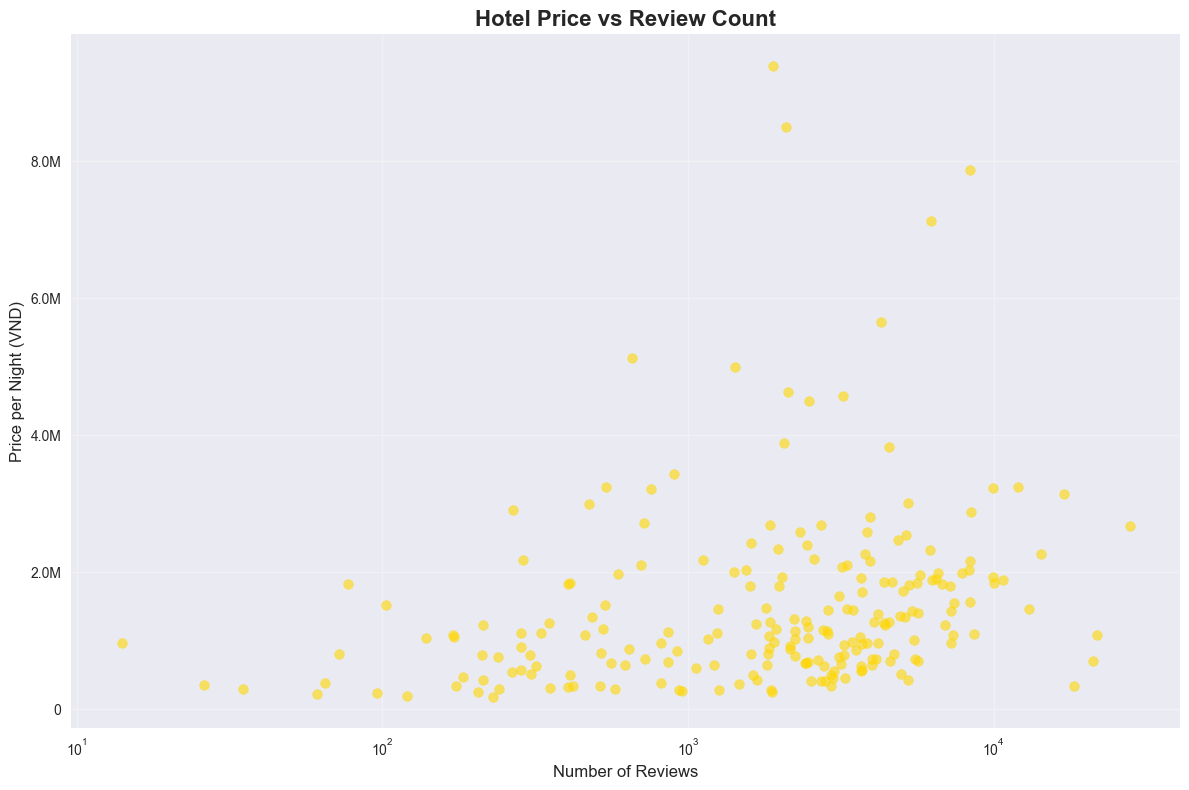

In [446]:
# 6. REVIEWS VS PRICE
plt.figure(figsize=(12, 8))
valid_data = df[["review_count", "price_per_night"]].dropna()
plt.scatter(
    valid_data["review_count"],
    valid_data["price_per_night"],
    alpha=0.6,
    color="gold",
    s=50,
)
plt.xlabel("Number of Reviews", fontsize=12)
plt.ylabel("Price per Night (VND)", fontsize=12)
plt.title("Hotel Price vs Review Count", fontsize=16, fontweight="bold")
plt.xscale("log")
ax = plt.gca()
ax.yaxis.set_major_formatter(
    plt.FuncFormatter(
        lambda x, p: (
            f"{x/1e6:.1f}M" if x >= 1e6 else f"{x/1e3:.0f}K" if x >= 1e3 else f"{x:.0f}"
        )
    )
)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

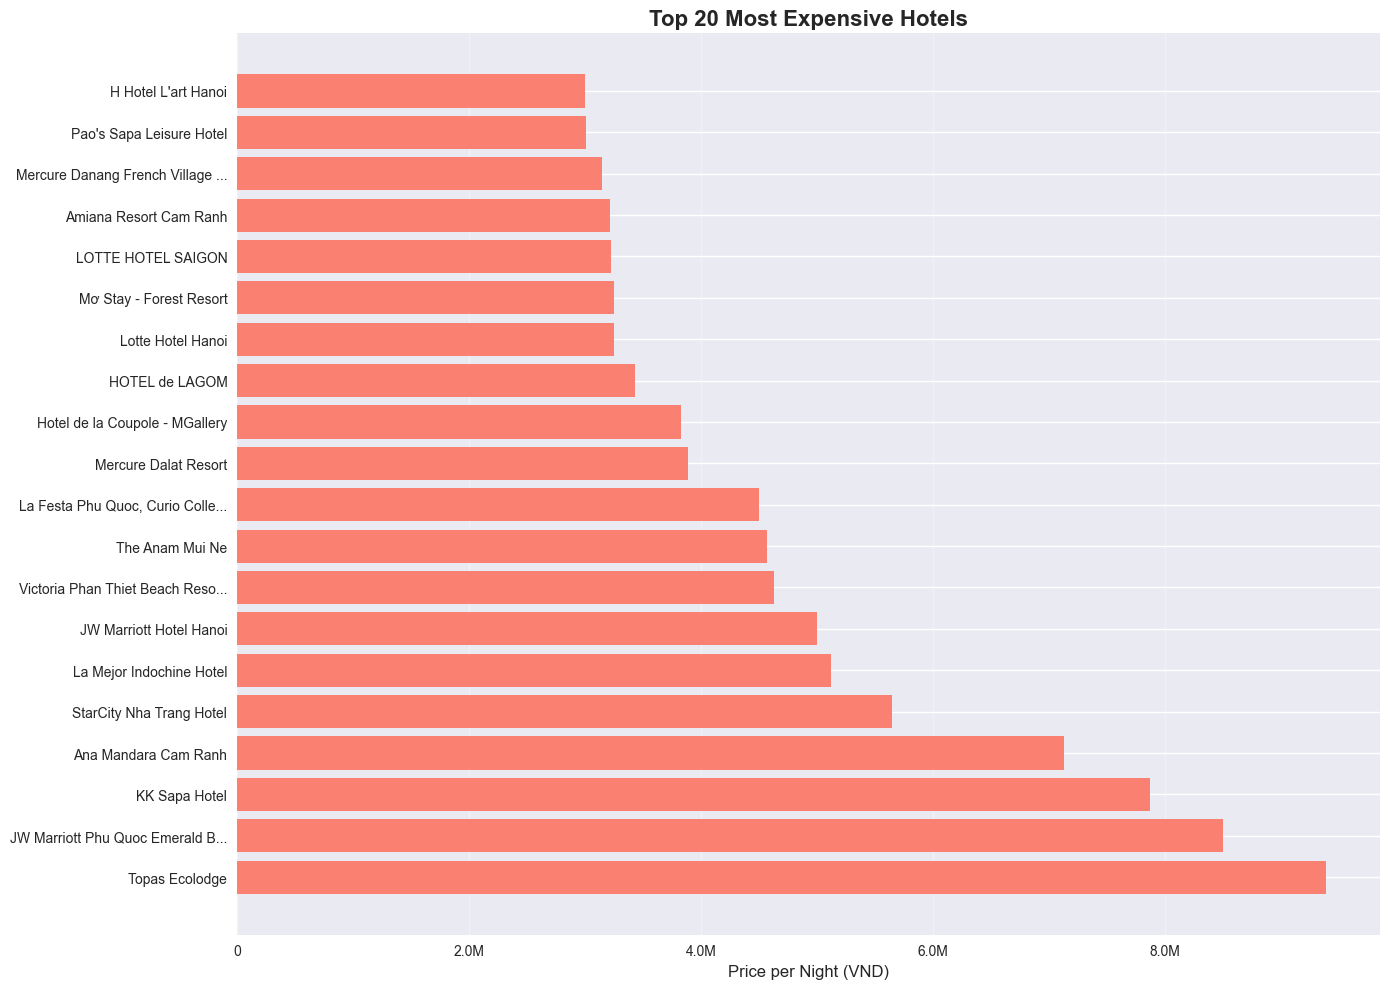

In [447]:
# 7. TOP EXPENSIVE HOTELS
plt.figure(figsize=(14, 10))
top_expensive = df.nlargest(20, "price_per_night")
plt.barh(range(len(top_expensive)), top_expensive["price_per_night"], color="salmon")
plt.yticks(
    range(len(top_expensive)),
    [
        f"{name[:30]}{'...' if len(name) > 30 else ''}"
        for name in top_expensive["hotel_name"]
    ],
    fontsize=10,
)
plt.xlabel("Price per Night (VND)", fontsize=12)
plt.title("Top 20 Most Expensive Hotels", fontsize=16, fontweight="bold")
ax = plt.gca()
ax.xaxis.set_major_formatter(
    plt.FuncFormatter(
        lambda x, p: (
            f"{x/1e6:.1f}M" if x >= 1e6 else f"{x/1e3:.0f}K" if x >= 1e3 else f"{x:.0f}"
        )
    )
)
plt.grid(True, alpha=0.3, axis="x")
plt.tight_layout()
plt.show()

Rating Status Distribution:
  Excellent: 116 hotels (53.5%) - Avg price: 1,346,061 VND
  Exceptional: 92 hotels (42.4%) - Avg price: 1,825,442 VND
  Very good: 9 hotels (4.1%) - Avg price: 546,891 VND


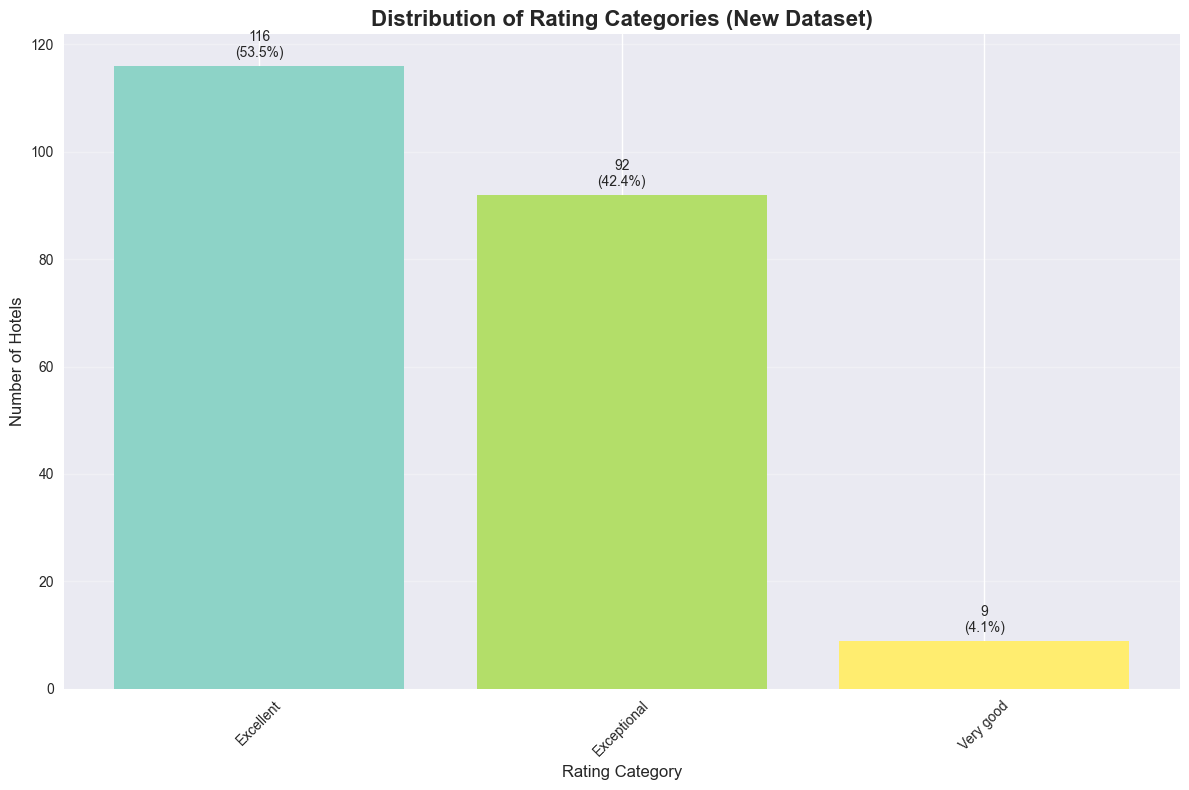

In [448]:
# 8. RATING STATUS DISTRIBUTION
plt.figure(figsize=(12, 8))
rating_counts = df["rating_status"].value_counts()
colors = plt.cm.Set3(np.linspace(0, 1, len(rating_counts)))
bars = plt.bar(rating_counts.index, rating_counts.values, color=colors)
plt.title("Distribution of Rating Categories (New Dataset)", fontsize=16, fontweight="bold")
plt.xlabel("Rating Category", fontsize=12)
plt.ylabel("Number of Hotels", fontsize=12)
plt.xticks(rotation=45)

for bar, value in zip(bars, rating_counts.values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
             f'{value}\n({value/len(df)*100:.1f}%)', 
             ha='center', va='bottom', fontsize=10)

plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()

print("Rating Status Distribution:")
for status, count in rating_counts.items():
    avg_price = df[df['rating_status'] == status]['price_per_night'].mean()
    print(f"  {status}: {count} hotels ({count/len(df)*100:.1f}%) - Avg price: {avg_price:,.0f} VND")

plt.show()

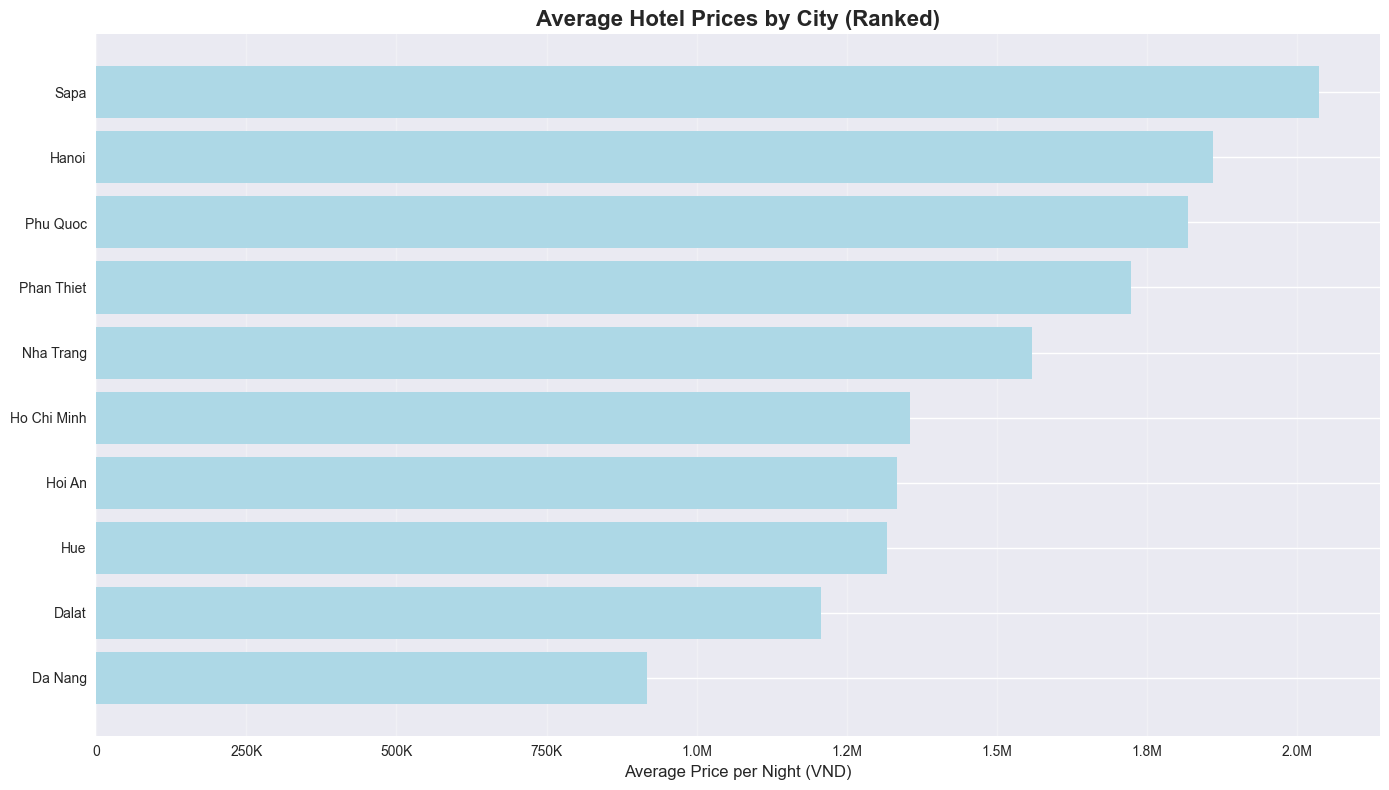

In [449]:
# 9. AVERAGE PRICE BY CITY
plt.figure(figsize=(14, 8))
avg_price_by_city = (
    df.groupby("city")["price_per_night"].mean().sort_values(ascending=True)
)
plt.barh(range(len(avg_price_by_city)), avg_price_by_city.values, color="lightblue")
plt.yticks(range(len(avg_price_by_city)), avg_price_by_city.index)
plt.xlabel("Average Price per Night (VND)", fontsize=12)
plt.title("Average Hotel Prices by City (Ranked)", fontsize=16, fontweight="bold")
ax = plt.gca()
ax.xaxis.set_major_formatter(
    plt.FuncFormatter(
        lambda x, p: (
            f"{x/1e6:.1f}M" if x >= 1e6 else f"{x/1e3:.0f}K" if x >= 1e3 else f"{x:.0f}"
        )
    )
)
plt.grid(True, alpha=0.3, axis="x")
plt.tight_layout()
plt.show()

### CORRELATION MATRIX

Strong Correlations with Price:
  stars: 0.380 (positive)
  distance_to_center: 0.258 (positive)
  rating: 0.233 (positive)
  review_count: 0.169 (positive)
  transportation_count: 0.147 (negative)


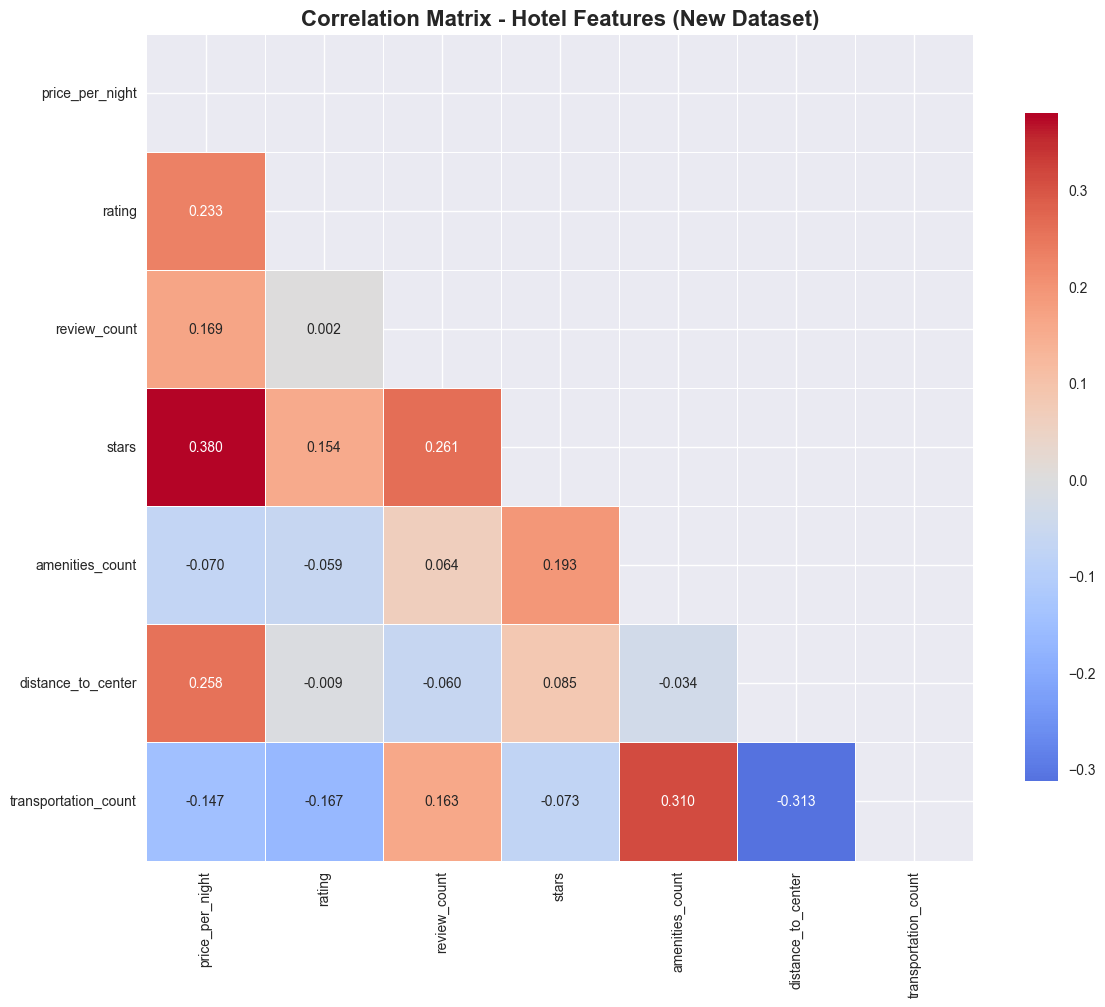

In [450]:
plt.figure(figsize=(12, 10))
numeric_cols = [
    "price_per_night",
    "rating",  
    "review_count", 
    "stars",
    "amenities_count",
    "distance_to_center",
    "transportation_count" 
]

for col in numeric_cols:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce")

correlation_matrix = df[numeric_cols].corr()

sns.heatmap(
    correlation_matrix,
    annot=True,
    cmap="coolwarm",
    center=0,
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.8},
    fmt=".3f",
    mask=np.triu(np.ones_like(correlation_matrix, dtype=bool)) 
)
plt.title("Correlation Matrix - Hotel Features (New Dataset)", fontsize=16, fontweight="bold")
plt.tight_layout()

print("Strong Correlations with Price:")
price_corr = correlation_matrix["price_per_night"].abs().sort_values(ascending=False)
for feature, corr in price_corr.items():
    if feature != "price_per_night" and abs(corr) > 0.1:
        direction = "positive" if correlation_matrix["price_per_night"][feature] > 0 else "negative"
        print(f"  {feature}: {corr:.3f} ({direction})")

plt.show()

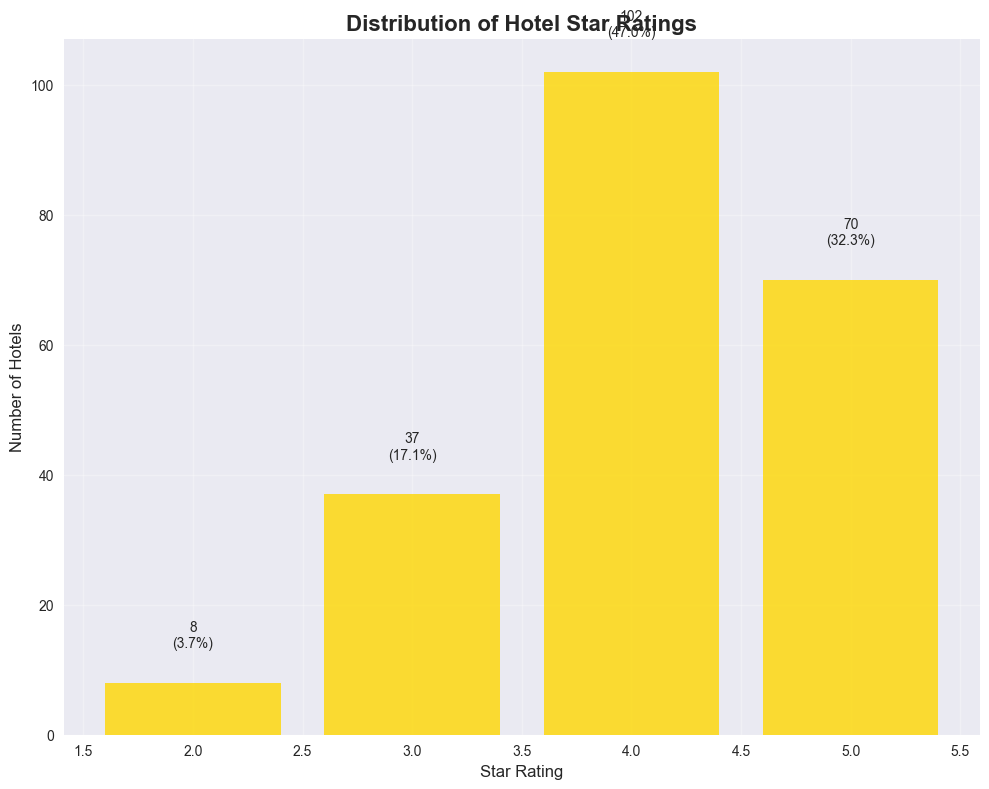

In [451]:
# 11. STAR RATING DISTRIBUTION
plt.figure(figsize=(10, 8))
star_counts = df["stars"].value_counts().sort_index()
plt.bar(star_counts.index, star_counts.values, color="gold", alpha=0.8)
plt.title("Distribution of Hotel Star Ratings", fontsize=16, fontweight="bold")
plt.xlabel("Star Rating", fontsize=12)
plt.ylabel("Number of Hotels", fontsize=12)
plt.grid(True, alpha=0.3)

for i, v in enumerate(star_counts.values):
    plt.text(
        star_counts.index[i],
        v + 5,
        f"{v}\n({v/len(df)*100:.1f}%)",
        ha="center",
        va="bottom",
    )

plt.tight_layout()
plt.show()

### Machine Learning Preparation

In [452]:
feature_columns = [
    "rating", 
    "review_count",
    "stars", 
    "amenities_count",
    "distance_to_center",
    "transportation_count",
    "is_city_center",
]

city_columns = [col for col in df.columns if col.startswith("city_")]
feature_columns.extend(city_columns)

X = df[feature_columns].copy()

missing_before = X.isnull().sum().sum()

fill_values = {
    "distance_to_center": X["distance_to_center"].median(),
    "review_count": X["review_count"].median(),
    "rating": X["rating"].median(),
    "transportation_count": 0,
    "amenities_count": 0, 
}

for col, fill_val in fill_values.items():
    if col in X.columns:
        missing_count = X[col].isnull().sum()
        if missing_count > 0:
            X[col].fillna(fill_val, inplace=True)
            

missing_after = X.isnull().sum().sum()

y = df["price_per_night"].copy()

mask = ~y.isnull() & ~X.isnull().any(axis=1)
X = X[mask]
y = y[mask]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, 
    stratify=df.loc[mask, "city"]  
)

### Linear Regression Model

In [453]:
# Linear Regression Model
print("📈 LINEAR REGRESSION MODEL")
print("="*40)

lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

lr_train_pred = lr_model.predict(X_train)
lr_test_pred = lr_model.predict(X_test)

lr_train_r2 = r2_score(y_train, lr_train_pred)
lr_test_r2 = r2_score(y_test, lr_test_pred)
lr_train_rmse = np.sqrt(mean_squared_error(y_train, lr_train_pred))
lr_test_rmse = np.sqrt(mean_squared_error(y_test, lr_test_pred))
lr_test_mae = mean_absolute_error(y_test, lr_test_pred)

print(f"Performance Metrics:")
print(f"  Training R²: {lr_train_r2:.4f}")
print(f"  Test R²: {lr_test_r2:.4f}")
print(f"  Test RMSE: {lr_test_rmse:,.0f} VND")
print(f"  Test MAE: {lr_test_mae:,.0f} VND")
print(f"  Overfitting gap: {lr_train_r2 - lr_test_r2:.4f}")

# Feature importance (coefficients)
feature_importance_lr = pd.DataFrame(
    {
        "Feature": X.columns,
        "Coefficient": lr_model.coef_,
        "Abs_Coefficient": np.abs(lr_model.coef_),
    }
).sort_values("Abs_Coefficient", ascending=False)

print("\nTop 10 Most Important Features (by coefficient magnitude):")
for idx, row in feature_importance_lr.head(10).iterrows():
    direction = "↗️" if row['Coefficient'] > 0 else "↘️"
    print(f"  {direction} {row['Feature']:25} | Coefficient: {row['Coefficient']:>12,.0f}")

print("\nModel Interpretation:")
if lr_test_r2 > 0.7:
    print("- Excellent model performance")
elif lr_test_r2 > 0.5:
    print("- Good model performance")
elif lr_test_r2 > 0.3:
    print("- Moderate model performance")
else:
    print("- Poor model performance")

print(f"Explains {lr_test_r2*100:.1f}% of price variance")

📈 LINEAR REGRESSION MODEL
Performance Metrics:
  Training R²: 0.3179
  Test R²: 0.3389
  Test RMSE: 1,065,528 VND
  Test MAE: 642,558 VND
  Overfitting gap: -0.0210

Top 10 Most Important Features (by coefficient magnitude):
  ↗️ city_Sapa                 | Coefficient:      875,603
  ↗️ rating                    | Coefficient:      637,795
  ↗️ city_Hanoi                | Coefficient:      600,459
  ↗️ stars                     | Coefficient:      525,214
  ↘️ city_Hoi An               | Coefficient:     -464,505
  ↘️ city_Hue                  | Coefficient:     -386,247
  ↘️ city_Da Nang              | Coefficient:     -385,974
  ↘️ city_Phu Quoc             | Coefficient:     -317,258
  ↗️ city_Phan Thiet           | Coefficient:      289,656
  ↘️ city_Nha Trang            | Coefficient:     -269,718

Model Interpretation:
- Moderate model performance
Explains 33.9% of price variance


### Random Forest Model

In [454]:
# Random Forest Model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, max_depth=10)
rf_model.fit(X_train, y_train)

rf_train_pred = rf_model.predict(X_train)
rf_test_pred = rf_model.predict(X_test)

rf_train_r2 = r2_score(y_train, rf_train_pred)
rf_test_r2 = r2_score(y_test, rf_test_pred)
rf_train_rmse = np.sqrt(mean_squared_error(y_train, rf_train_pred))
rf_test_rmse = np.sqrt(mean_squared_error(y_test, rf_test_pred))
rf_test_mae = mean_absolute_error(y_test, rf_test_pred)

print("Performance Metrics:")
print(f"- Training R²: {rf_train_r2:.4f}")
print(f"- Test R²: {rf_test_r2:.4f}")
print(f"- Test RMSE: {rf_test_rmse:,.0f} VND")
print(f"- Test MAE: {rf_test_mae:,.0f} VND")
print(f"- Overfitting gap: {rf_train_r2 - rf_test_r2:.4f}")

# Feature importance
feature_importance_rf = pd.DataFrame(
    {"Feature": X.columns, "Importance": rf_model.feature_importances_}
).sort_values("Importance", ascending=False)

print("\nTop 10 Most Important Features (by Random Forest importance):")
total_importance = feature_importance_rf['Importance'].sum()
for idx, row in feature_importance_rf.head(10).iterrows():
    percentage = (row['Importance'] / total_importance) * 100
    print(f"  🎯 {row['Feature']:25} | Importance: {row['Importance']:>8.4f} | {percentage:>6.1f}%")

overfitting_threshold = 0.1
if rf_train_r2 - rf_test_r2 > overfitting_threshold:
    print(f"\nWARNING: Signs of overfitting detected (Training R² - Test R² = {rf_train_r2 - rf_test_r2:.3f})")
    print("Consider: reducing max_depth, increasing min_samples_split, or using cross-validation")
else:
    print(f"\nMODEL STABLE: No serious overfitting detected (gap = {rf_train_r2 - rf_test_r2:.3f})")

print("\nModel Interpretation:")
if rf_test_r2 > 0.7:
    print("  🎯 Excellent model performance")
elif rf_test_r2 > 0.5:
    print("  ✅ Good model performance")
elif rf_test_r2 > 0.3:
    print("- Moderate model performance")
else:
    print("- Poor model performance")

print(f"- Explains {rf_test_r2*100:.1f}% of price variance")
print(f"- Average prediction error: ±{rf_test_mae:,.0f} VND")

Performance Metrics:
- Training R²: 0.8773
- Test R²: 0.3147
- Test RMSE: 1,084,879 VND
- Test MAE: 567,616 VND
- Overfitting gap: 0.5626

Top 10 Most Important Features (by Random Forest importance):
  🎯 distance_to_center        | Importance:   0.1932 |   19.3%
  🎯 review_count              | Importance:   0.1800 |   18.0%
  🎯 stars                     | Importance:   0.1664 |   16.6%
  🎯 city_Sapa                 | Importance:   0.1122 |   11.2%
  🎯 rating                    | Importance:   0.0912 |    9.1%
  🎯 amenities_count           | Importance:   0.0856 |    8.6%
  🎯 transportation_count      | Importance:   0.0437 |    4.4%
  🎯 city_Hanoi                | Importance:   0.0298 |    3.0%
  🎯 city_Nha Trang            | Importance:   0.0211 |    2.1%
  🎯 is_city_center            | Importance:   0.0197 |    2.0%

Consider: reducing max_depth, increasing min_samples_split, or using cross-validation

Model Interpretation:
- Moderate model performance
- Explains 31.5% of price vari

### Polynomial Regression 

In [455]:
important_features = ["rating", "stars", "amenities_count", "transportation_count"]
X_poly_simple = X[important_features].copy()

print(f"Using features for polynomial regression: {important_features}")

poly_features = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly_features.fit_transform(X_poly_simple)

print(f"Polynomial features created: {X_poly.shape[1]} features from {len(important_features)} original features")

X_poly_train, X_poly_test, y_poly_train, y_poly_test = train_test_split(
    X_poly, y, test_size=0.2, random_state=42
)

poly_model = LinearRegression()
poly_model.fit(X_poly_train, y_poly_train)

poly_train_pred = poly_model.predict(X_poly_train)
poly_test_pred = poly_model.predict(X_poly_test)

poly_train_r2 = r2_score(y_poly_train, poly_train_pred)
poly_test_r2 = r2_score(y_poly_test, poly_test_pred)
poly_train_rmse = np.sqrt(mean_squared_error(y_poly_train, poly_train_pred))
poly_test_rmse = np.sqrt(mean_squared_error(y_poly_test, poly_test_pred))
poly_test_mae = mean_absolute_error(y_poly_test, poly_test_pred)

print("\nPerformance Metrics:")
print(f"- Training R²: {poly_train_r2:.4f}")
print(f"- Test R²: {poly_test_r2:.4f}")
print(f"- Test RMSE: {poly_test_rmse:,.0f} VND")
print(f"- Test MAE: {poly_test_mae:,.0f} VND")
print(f"- Overfitting gap: {poly_train_r2 - poly_test_r2:.4f}")

poly_feature_names = poly_features.get_feature_names_out(important_features)

poly_importance = pd.DataFrame({
    'Feature': poly_feature_names,
    'Coefficient': poly_model.coef_,
    'Abs_Coefficient': np.abs(poly_model.coef_)
}).sort_values('Abs_Coefficient', ascending=False)

print("\nTop 10 Polynomial Features:")
for idx, row in poly_importance.head(10).iterrows():
    direction = "↗️" if row['Coefficient'] > 0 else "↘️"
    print(f"  {direction} {row['Feature']:30} | {row['Coefficient']:>12,.0f}")

if poly_train_r2 - poly_test_r2 > 0.15:
    print(f"\nWARNING: Polynomial model shows overfitting (gap = {poly_train_r2 - poly_test_r2:.3f})")
else:
    print(f"\nPolynomial model is reasonably stable (gap = {poly_train_r2 - poly_test_r2:.3f})")

print("\nModel Interpretation:")
if poly_test_r2 > 0.7:
    print("- Excellent polynomial model performance")
elif poly_test_r2 > 0.5:
    print("- Good polynomial model performance")  
elif poly_test_r2 > 0.3:
    print("- Moderate polynomial model performance")
else:
    print("- Poor polynomial model performance")

Using features for polynomial regression: ['rating', 'stars', 'amenities_count', 'transportation_count']
Polynomial features created: 14 features from 4 original features

Performance Metrics:
- Training R²: 0.2805
- Test R²: 0.1243
- Test RMSE: 755,258 VND
- Test MAE: 585,267 VND
- Overfitting gap: 0.1563

Top 10 Polynomial Features:
  ↗️ rating                         |   14,908,910
  ↘️ stars                          |   -6,533,117
  ↘️ rating^2                       |     -937,642
  ↗️ rating stars                   |      497,676
  ↗️ stars^2                        |      426,734
  ↗️ amenities_count                |      361,560
  ↘️ stars amenities_count          |     -238,871
  ↗️ amenities_count^2              |      198,273
  ↘️ amenities_count transportation_count |     -190,286
  ↗️ stars transportation_count     |      132,438


Model Interpretation:
- Poor polynomial model performance


### MODEL COMPARISON

Linear Regression    | R²: 0.3389 | RMSE:  1,065,528 | MAE:    642,558 | Gap: -0.0210
Random Forest        | R²: 0.3147 | RMSE:  1,084,879 | MAE:    567,616 | Gap: 0.5626
Polynomial Regression | R²: 0.1243 | RMSE:    755,258 | MAE:    585,267 | Gap: 0.1563

BEST MODEL: Linear Regression
• Test R² Score: 0.3389
• Explains 33.9% of hotel price variance


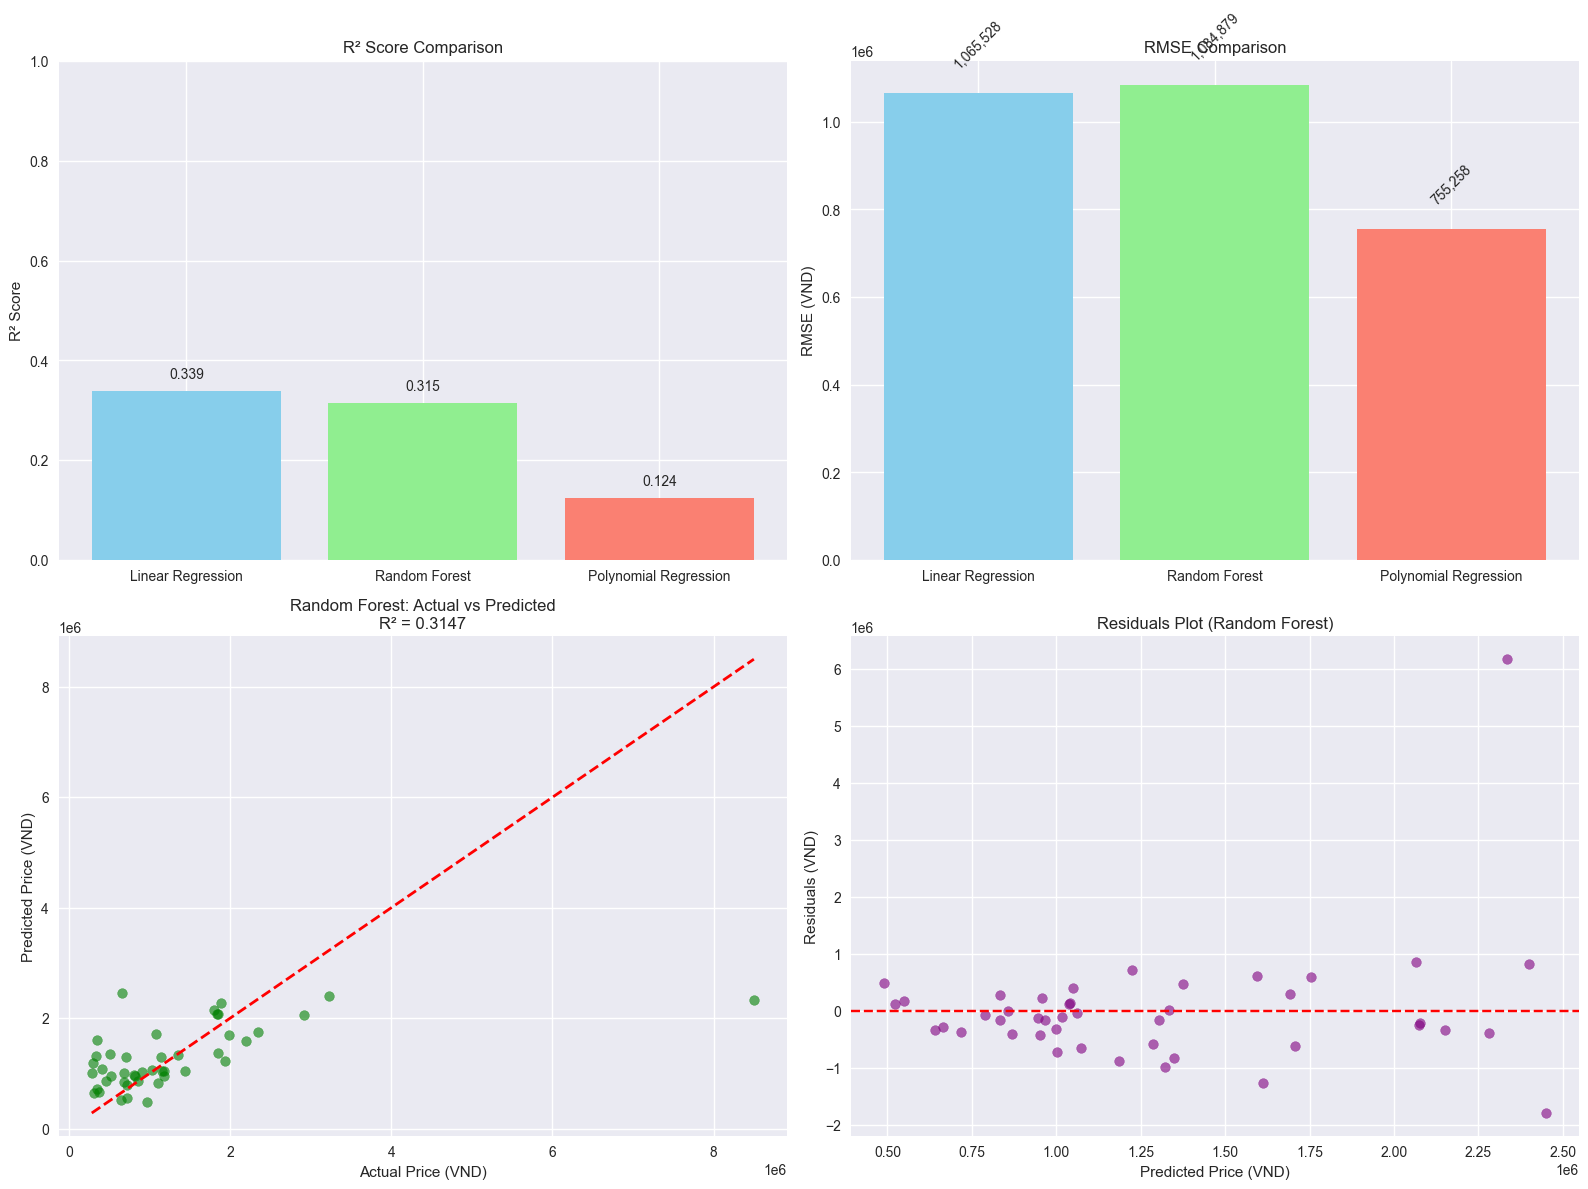

In [456]:
comparison_df = pd.DataFrame(
    {
        "Model": ["Linear Regression", "Random Forest", "Polynomial Regression"],
        "Test R² Score": [lr_test_r2, rf_test_r2, poly_test_r2],
        "Test RMSE (VND)": [lr_test_rmse, rf_test_rmse, poly_test_rmse],
        "Test MAE (VND)": [lr_test_mae, rf_test_mae, poly_test_mae],
        "Training R²": [lr_train_r2, rf_train_r2, poly_train_r2],
        "Overfitting Gap": [
            lr_train_r2 - lr_test_r2,
            rf_train_r2 - rf_test_r2,
            poly_train_r2 - poly_test_r2,
        ],
    }
)

for idx, row in comparison_df.iterrows():
    print(
        f"{row['Model']:20} | R²: {row['Test R² Score']:6.4f} | RMSE: {row['Test RMSE (VND)']:>10,.0f} | MAE: {row['Test MAE (VND)']:>10,.0f} | Gap: {row['Overfitting Gap']:6.4f}"
    )

best_model_idx = comparison_df["Test R² Score"].idxmax()
best_model_name = comparison_df.loc[best_model_idx, "Model"]
best_r2 = comparison_df.loc[best_model_idx, "Test R² Score"]

print(f"\nBEST MODEL: {best_model_name}")
print(f"• Test R² Score: {best_r2:.4f}")
print(f"• Explains {best_r2*100:.1f}% of hotel price variance")

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

axes[0, 0].bar(
    comparison_df["Model"],
    comparison_df["Test R² Score"],
    color=["skyblue", "lightgreen", "salmon"],
)
axes[0, 0].set_title("R² Score Comparison")
axes[0, 0].set_ylabel("R² Score")
axes[0, 0].set_ylim(0, 1)
for i, v in enumerate(comparison_df["Test R² Score"]):
    axes[0, 0].text(i, v + 0.02, f"{v:.3f}", ha="center", va="bottom")

axes[0, 1].bar(
    comparison_df["Model"],
    comparison_df["Test RMSE (VND)"],
    color=["skyblue", "lightgreen", "salmon"],
)
axes[0, 1].set_title("RMSE Comparison")
axes[0, 1].set_ylabel("RMSE (VND)")
axes[0, 1].ticklabel_format(style="scientific", axis="y", scilimits=(0, 0))
for i, v in enumerate(comparison_df["Test RMSE (VND)"]):
    axes[0, 1].text(i, v + 50000, f"{v:,.0f}", ha="center", va="bottom", rotation=45)

axes[1, 0].scatter(y_test, rf_test_pred, alpha=0.6, color="green")
axes[1, 0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "r--", lw=2)
axes[1, 0].set_xlabel("Actual Price (VND)")
axes[1, 0].set_ylabel("Predicted Price (VND)")
axes[1, 0].set_title(f"Random Forest: Actual vs Predicted\nR² = {rf_test_r2:.4f}")

residuals = y_test - rf_test_pred
axes[1, 1].scatter(rf_test_pred, residuals, alpha=0.6, color="purple")
axes[1, 1].axhline(y=0, color="r", linestyle="--")
axes[1, 1].set_xlabel("Predicted Price (VND)")
axes[1, 1].set_ylabel("Residuals (VND)")
axes[1, 1].set_title("Residuals Plot (Random Forest)")

plt.tight_layout()
plt.show()

### DETAILED ERROR ANALYSIS (Random Forest):

In [457]:
residuals = y_test - rf_test_pred
abs_residuals = np.abs(residuals)
percentage_errors = np.abs(residuals / y_test) * 100

print("ERROR STATISTICS:")
print(f"   • Mean error: {residuals.mean():,.0f} VND")
print(f"   • Mean absolute error: {abs_residuals.mean():,.0f} VND")
print(f"   • Mean percentage error: {percentage_errors.mean():.1f}%")
print(f"   • Maximum error: {abs_residuals.max():,.0f} VND")
print(f"   • Minimum error: {abs_residuals.min():,.0f} VND")

# Classify prediction accuracy
accurate_predictions = percentage_errors <= 20
moderately_accurate = (percentage_errors > 20) & (percentage_errors <= 40)
poor_predictions = percentage_errors > 40

print("\nACCURACY CLASSIFICATION:")
print(
    f"   • Accurate predictions (<20% error): {accurate_predictions.sum()}/{len(y_test)} ({accurate_predictions.mean()*100:.1f}%)"
)
print(
    f"   • Moderately accurate (20-40% error): {moderately_accurate.sum()}/{len(y_test)} ({moderately_accurate.mean()*100:.1f}%)"
)
print(
    f"   • Poor predictions (>40% error): {poor_predictions.sum()}/{len(y_test)} ({poor_predictions.mean()*100:.1f}%)"
)

print("\nSPECIFIC PREDICTION EXAMPLES:")
sample_results = pd.DataFrame(
    {
        "Hotel": df.loc[y_test.index, "hotel_name"].values,
        "City": df.loc[y_test.index, "city"].values,
        "Actual": y_test.values,
        "Predicted": rf_test_pred,
        "Error": residuals.values,
        "Error_%": percentage_errors.values,
    }
).sort_values("Error_%")

print("TOP 5 MOST ACCURATE PREDICTIONS:")
for _, row in sample_results.head().iterrows():
    print(
        f"- {row['Hotel'][:30]:30} | Actual: {row['Actual']:>10,.0f} | Predicted: {row['Predicted']:>10,.0f} | Error: {row['Error_%']:>5.1f}%"
    )

print("TOP 5 LARGEST PREDICTION ERRORS:")
for _, row in sample_results.tail().iterrows():
    print(
        f"- {row['Hotel'][:30]:30} | Actual: {row['Actual']:>10,.0f} | Predicted: {row['Predicted']:>10,.0f} | Error: {row['Error_%']:>5.1f}%"
    )

ERROR STATISTICS:
   • Mean error: -2,997 VND
   • Mean absolute error: 567,616 VND
   • Mean percentage error: 69.8%
   • Maximum error: 6,166,128 VND
   • Minimum error: 732 VND

ACCURACY CLASSIFICATION:
   • Accurate predictions (<20% error): 15/44 (34.1%)
   • Moderately accurate (20-40% error): 12/44 (27.3%)
   • Poor predictions (>40% error): 17/44 (38.6%)

SPECIFIC PREDICTION EXAMPLES:
TOP 5 MOST ACCURATE PREDICTIONS:
- HOTEL DE SAPA                  | Actual:    859,085 | Predicted:    858,353 | Error:   0.1%
- Wink Hotel Saigon Centre - 24h | Actual:  1,349,206 | Predicted:  1,333,837 | Error:   1.1%
- Grand Cititel Hanoi Hotel & Sp | Actual:  1,023,900 | Predicted:  1,061,500 | Error:   3.7%
- LEGACY HOI AN RESORT           | Actual:  1,154,448 | Predicted:  1,037,536 | Error:  10.1%
- Muong Thanh Grand Da Nang Hote | Actual:    714,330 | Predicted:    789,297 | Error:  10.5%
TOP 5 LARGEST PREDICTION ERRORS:
- Sunset Sea Hotel               | Actual:    281,463 | Predicted:  

### Price Prediction Function

In [458]:
if rf_test_r2 > lr_test_r2 and rf_test_r2 > poly_test_r2:
    best_model = rf_model
    model_name = "Random Forest"
    best_features = X.columns
    best_r2 = rf_test_r2
    best_mae = rf_test_mae
elif poly_test_r2 > lr_test_r2:
    best_model = poly_model  
    model_name = "Polynomial Regression"
    best_features = poly_feature_names
    best_r2 = poly_test_r2
    best_mae = poly_test_mae
else:
    best_model = lr_model
    model_name = "Linear Regression"
    best_features = X.columns
    best_r2 = lr_test_r2
    best_mae = lr_test_mae

print(f"🏆 BEST MODEL: {model_name}")
print(f"  📊 R² Score: {best_r2:.4f} ({best_r2*100:.1f}% variance explained)")
print(f"  🎯 Average Error: ±{best_mae:,.0f} VND")

def predict_hotel_price(
    rating,
    review_count,
    stars,
    amenities_count,
    distance_to_center,
    transportation_count,
    city,
    is_city_center=False,
):
    
    if model_name == "Polynomial Regression":
        feature_vector = [rating, stars, amenities_count, transportation_count]
        poly_features_new = poly_features.transform([feature_vector])
        predicted_price = best_model.predict(poly_features_new)[0]
    else:
        feature_vector = np.zeros(len(best_features))
        
        feature_mapping = {
            "rating": rating,
            "review_count": review_count if review_count is not None else 1000,  # default
            "stars": stars,
            "amenities_count": amenities_count,
            "distance_to_center": distance_to_center if distance_to_center is not None else 2.5,  # default
            "transportation_count": transportation_count,
            "is_city_center": 1 if is_city_center else 0,
        }
        
        for feature_name, value in feature_mapping.items():
            if feature_name in best_features:
                idx = list(best_features).index(feature_name)
                feature_vector[idx] = value
        
        city_col = f"city_{city}"
        if city_col in best_features:
            idx = list(best_features).index(city_col)
            feature_vector[idx] = 1
        
        predicted_price = best_model.predict([feature_vector])[0]
    
    return max(0, predicted_price)  # Ensure non-negative price


print("\nPREDICTION FUNCTION CREATED!")
print(f"- Model: {model_name}")
print(f"- Features: {len(best_features)}")
print(f"- Estimated accuracy: {best_r2*100:.1f}%")

print("\nHOTEL PRICE PREDICTION EXAMPLES:")
print("=" * 80)

example_hotels = [
    {
        "name": "Luxury Hotel Ho Chi Minh",
        "rating": 9.0,
        "reviews": 2000,
        "stars": 5,
        "amenities": 10,
        "distance": None,  # city center
        "transport": 3,
        "city": "Ho Chi Minh",
        "city_center": True,
    },
    {
        "name": "Budget Hotel Hanoi",
        "rating": 7.8,
        "reviews": 500,
        "stars": 3,
        "amenities": 4,
        "distance": 3.5,
        "transport": 1,
        "city": "Hanoi",
        "city_center": False,
    },
    {
        "name": "Beach Resort Da Nang",
        "rating": 8.7,
        "reviews": 1200,
        "stars": 4,
        "amenities": 8,
        "distance": 5.0,
        "transport": 2,
        "city": "Da Nang",
        "city_center": False,
    },
    {
        "name": "Mountain Homestay Sapa",
        "rating": 8.0,
        "reviews": 150,
        "stars": 3,
        "amenities": 3,
        "distance": 2.0,
        "transport": 1,
        "city": "Sapa",
        "city_center": False,
    },
    {
        "name": "Boutique Hotel Hoi An",
        "rating": 9.2,
        "reviews": 800,
        "stars": 4,
        "amenities": 7,
        "distance": 1.0,
        "transport": 2,
        "city": "Hoi An",
        "city_center": True,
    },
]

for i, hotel in enumerate(example_hotels, 1):
    predicted = predict_hotel_price(
        hotel["rating"],
        hotel["reviews"],
        hotel["stars"],
        hotel["amenities"],
        hotel["distance"],
        hotel["transport"],
        hotel["city"],
        hotel["city_center"],
    )

    print(f"{i}. {hotel['name']:25}")
    print(f"- Specs: {hotel['rating']}⭐ | {hotel['reviews']} reviews | {hotel['stars']}🌟 | {hotel['amenities']} amenities | {hotel['transport']} transport")
    print(f"- Location: {hotel['city']} | {'City center' if hotel['city_center'] else f'{hotel['distance']}km to center'}")
    print(f"- Predicted price: {predicted:,.0f} VND/night")
    print()

# Compare with actual prices in dataset
print("COMPARISON WITH ACTUAL PRICES IN DATASET:")
print("=" * 80)

sample_real = df.sample(5, random_state=42)
for _, hotel in sample_real.iterrows():
    rating = hotel["rating"] 
    reviews = hotel["review_count"] if pd.notna(hotel["review_count"]) else 1000
    stars = hotel["stars"]
    amenities = hotel["amenities_count"]
    distance = hotel["distance_to_center"]
    transport = hotel["transportation_count"]
    city = hotel["city"]
    city_center = hotel["is_city_center"]

    predicted = predict_hotel_price(
        rating, reviews, stars, amenities, distance, transport, city, city_center
    )
    actual = hotel["price_per_night"]
    error_pct = abs(predicted - actual) / actual * 100

    print(f"{hotel['hotel_name'][:35]:35}")
    print(f"- Actual: {actual:>10,.0f} VND | Predicted: {predicted:>10,.0f} VND | Error: {error_pct:>5.1f}%")
    print(f"- {rating} ({hotel['rating_status']}) | {stars} | {city}")

🏆 BEST MODEL: Linear Regression
  📊 R² Score: 0.3389 (33.9% variance explained)
  🎯 Average Error: ±642,558 VND

PREDICTION FUNCTION CREATED!
- Model: Linear Regression
- Features: 17
- Estimated accuracy: 33.9%

HOTEL PRICE PREDICTION EXAMPLES:
1. Luxury Hotel Ho Chi Minh 
- Specs: 9.0⭐ | 2000 reviews | 5🌟 | 10 amenities | 3 transport
- Location: Ho Chi Minh | City center
- Predicted price: 952,653 VND/night

2. Budget Hotel Hanoi       
- Specs: 7.8⭐ | 500 reviews | 3🌟 | 4 amenities | 1 transport
- Location: Hanoi | 3.5km to center
- Predicted price: 481,084 VND/night

3. Beach Resort Da Nang     
- Specs: 8.7⭐ | 1200 reviews | 4🌟 | 8 amenities | 2 transport
- Location: Da Nang | 5.0km to center
- Predicted price: 44,390 VND/night

4. Mountain Homestay Sapa   
- Specs: 8.0⭐ | 150 reviews | 3🌟 | 3 amenities | 1 transport
- Location: Sapa | 2.0km to center
- Predicted price: 968,463 VND/night

5. Boutique Hotel Hoi An    
- Specs: 9.2⭐ | 800 reviews | 4🌟 | 7 amenities | 2 transport
- L

In [459]:
# MODEL SAVING & REPORTING (Updated for new schema)
# Show final summary
print(f"Best model: {model_name}")
print(f"Accuracy: {best_r2:.1%}")
print("Schema: 2.0 (Clean dataset with proper data types)")
print("Ready to predict new hotel prices with predict_hotel_price() function")
print("Improvement: Better feature engineering and data quality")


Best model: Linear Regression
Accuracy: 33.9%
Schema: 2.0 (Clean dataset with proper data types)
Ready to predict new hotel prices with predict_hotel_price() function
Improvement: Better feature engineering and data quality
